In [1]:
import pandas as pd 
import numpy as np 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from src.files.fasta import FASTAFile
from Bio import Phylo
from itertools import product, combinations
from utils import *
from src.coevolution import get_scores
from scipy.stats import mannwhitneyu
from src.files.itol import *
import io
from src.tree import *  

%load_ext autoreload 
%autoreload 2

palette = {'pyl+':'steelblue', 'pyl-':'gray'}

In [2]:
# (1) (Competition hypothesis) Generic reduction in termination efficiency (not necessarily UAG specific) allows the Pyl tRNA to preferentially outcompete aRF1
#   and the reduction in termination efficiency does not have a substantial effect when no cognate tRNA is present. This may not manifest 
#   as a mutation at the N-terminus, but could be at the C or M-terminus. 
# (2) (Re-coding hypothesis) aRF1 mutations which greatly reduce or abolish binding to the UAG stop codon, while largely maintaining specificity for the other two 
#   stop codons. These mutations are more likely to be located at the N-terminus. Such alterations may manifest as reduced selective pressure
#   on otherwise highly-conserved residues, or as strong conservation of specific mutations which achieve the desired effect. This would depend on the exact 
#   mechanism altered by the mutation (does it behave like gain-of-function or loss-of-function?)
# (3) (Null hypothesis) there are no significant changes to aRF1 in "re-coded" organisms, as disruption of aRF1 functionality has widespread
#   implications for the success of translation termination on all proteins, and competition with Pyl tRNA is sufficient. 

# Base on the ciliate literature, we cannot necessarily expect that a single strategy is used to achieve a reduction of aRF1 performance; it is likely that
# different clades have developed different approaches. Regardless, we should be looking for residues which are highly-correlated with whether or not 
# an organism is nominally re-coded. These are not necessarily conserved, as mentioned above, which means that their effect may be essentially impossible
# to disentangle from phylogenetic signal. 

# In an attempt to reduce noise from phylogenetic signal, we can focus on the two orders which have both Pyl- and
# Pyl+ organisms

# We limit the search to only low-UAG Pyl+ genomes, which, in principle, have had Pyl machinery long enough to adjusts their stop codon usage profile. These genomes are
# most likely to have developed commensurate changes in aRF1, in part because loss of aRF1 functionality would not result in widespread erroneous readthrough. 


In [3]:
# Going to take a new approach to control for phylogeny based on the GTDB data... 
# Assumption is that differences between closely-related Pyl+ and Pyl- organisms

# (1) Build amino acid frequency profiles for individual genuses (all except Methanosarcina are homogenous for Pyl). 
# (2) Compare the amino acid frequency distributions between genuses in the same family. Family is the minimum taxonomic level which 
#   is non-homgenous, though I should check on the number of non-homogenous families to ensure the number of pairwise comparisons is enough. 

# Why set a maximum phylogenetic distance? Partially computational limitations, also partly because of noise which may be introduced due to the 
# fact that noise might be introduced due to the fact that all of the Pyl+ organisms are constrained to two orders, and
# the vast majority of the dataset is Pyl-. This means that a signal might arise between Pyl+ and Pyl- simply due to evolutionary
# distance between orders. 

In [30]:
arf1_df = load_arf1_dataset(exclude_genome_ids=['GCA_003164755.1'])

print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'pyl+').sum())
arf1_df = arf1_df[arf1_df.category != 'pyl+'].copy()
arf1_df['category'] = arf1_df.category.replace({'pyl+ recoded':'pyl+'})

alignment_df = load_msa('../data/arf1_cleaned.afa', ids=arf1_df.index, conservation_threshold=0.8)

Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories: 73


In [5]:
# Confirm that all genuses are homogenous, either all Pyl+ or Pyl-. 
for genus, df in arf1_df.groupby('genus'):
    assert df.category.nunique() == 1, f'The genus {genus} contains both Pyl+ and Pyl- organisms.'

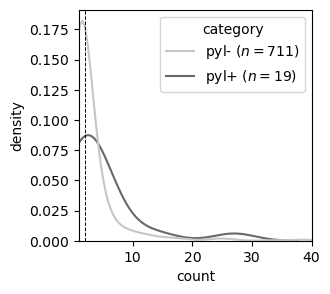

In [6]:
# Look at the distribution of genus sizes. 
fig, ax = plt.subplots(figsize=(3, 3))

min_genus_size = 2

figure_df = pd.DataFrame(arf1_df.genus.value_counts())
figure_df['category'] = arf1_df.groupby('genus').category.first()
figure_df['category'] = figure_df.category.map({category:f'{category} ($n={len(df)}$)' for category, df in figure_df.groupby('category')})

sns.kdeplot(figure_df, x='count', hue='category', common_norm=False, palette='Grays')
ax.set_xlim(xmin=1, xmax=40)
ax.set_ylabel('density')

ax.axvline(min_genus_size, ls='--', color='black', lw=0.7)
genuses = figure_df[figure_df['count'] >= min_genus_size].index.values 

plt.show()

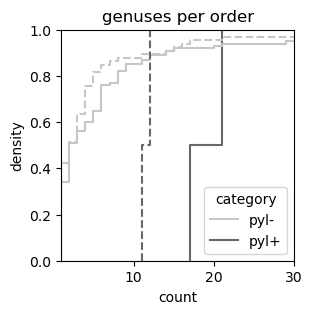

In [7]:
# Next want to look at how many genuses per family (or other level), particularly families which have both Pyl+ and 
# Pyl- genuses. 
level = 'order'
fig, ax = plt.subplots(figsize=(3, 3))

def plot_genus_count_distribution(arf1_df:pd.DataFrame, level:str=level, ax:plt.Axes=None, ls:str='-', legend:bool=True):
    figure_df = pd.DataFrame(arf1_df.groupby(level).apply(lambda df : df.genus.nunique(), include_groups=False))
    figure_df = figure_df.rename(columns={0:'count'})
    figure_df['category'] = arf1_df.groupby(level).apply(lambda df : 'pyl+' if ('pyl+' in df.category.unique()) else 'pyl-', include_groups=False)
    sns.ecdfplot(figure_df, x='count', hue='category',  palette='Grays', ls=ls, legend=legend)

plot_genus_count_distribution(arf1_df, level=level, ax=ax)
plot_genus_count_distribution(arf1_df[arf1_df.genus.isin(genuses)].copy(), level=level, ax=ax, ls='--', legend=False)

ax.set_xlim(xmin=1, xmax=30)
ax.set_ylabel('density')
ax.set_title(f'genuses per {level}')

plt.show()

# About half of the genuses in the Pyl+ orders contain only one member, which is making me a bit hesitant to filter based 
# on number of organisms per genus... 

In [9]:
def _annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')

alignment_df = load_msa('../data/arf1_cleaned.afa', ids=arf1_df.index, conservation_threshold=0.8)
seq = ''.join(alignment_df.iloc[0])
domain_boundaries = get_domain_boundaries(seq)

get_domain_boundaries: NIKS boundaries 54-58.
get_domain_boundaries: YxCxxxF boundaries 118-125.
get_domain_boundaries: GTS boundaries 22-25.


In [ ]:
# Build a matrix for each genus based on the aRF1 MSA, where the columns correspond to the frequency of an amino acid and the rows
# correspond to a position, resulting in a final matrix shape of (416, 20).

aas = 'ACDEFGHIKLMNPQRSTVWY' 
# aas = ''.join(list(dayhoff.values()))


def _get_frequencies(col, alphabet:list=list(aas)):
    symbols, counts = np.unique(col, return_counts=True)
    counts = dict(zip(symbols, counts))
    counts = np.array([counts.get(a, 0) for a in alphabet])
    return counts / counts.sum() if (counts.sum() > 0) else np.array([np.nan] * len(alphabet))

def get_frequency_matrix(ids:list, alignment_df:pd.DataFrame=alignment_df):
    alignment_df = alignment_df.loc[ids].copy()
    m = np.empty((len(alignment_df.columns), len(aas)))
    for i in range(len(alignment_df.columns)):
        m[i, :] = _get_frequencies(alignment_df[i].values)
    return m 

M = dict()
for genus, df in arf1_df.groupby('genus'):
    # if len(df) >= min_genus_size:
    M[genus] = get_frequency_matrix(df.index.values)



In [ ]:
# levels = ['genus', 'family', 'order']

# def get_pairs(arf1_df:pd.DataFrame, level='order'):
#     pair_df = list()

#     for taxon, df in arf1_df.groupby(level): # Only compare things within the same order. 
#         df = df[levels + ['category']].drop_duplicates('genus')
#         for row_1, row_2 in combinations(list(df.itertuples()), 2):

#             category = ' vs. '.join(sorted([row_1.category, row_2.category]))
#             row = {level:taxon}
#             row['category'] = category
#             for level_ in ['genus', 'family']:
#                 row.update({f'{level_}_1':getattr(row_1, level_), f'{level_}_2':getattr(row_2, level_)})
#             pair_df.append(row)
#     pair_df = pd.DataFrame(pair_df)
#     return pair_df 

# pair_df = get_pairs(arf1_df) #.category.value_counts()


In [ ]:
# def get_pair_divergence_scores(pair_df):
#     scores = list()
#     index = list()
#     for row in pair_df.itertuples():
#         if not ((row.genus_1 in M) and (row.genus_2 in M)):
#             continue
#         m_1, m_2 = M[row.genus_1], M[row.genus_2]
#         scores.append(np.linalg.norm(m_1 - m_2, axis=1, ord=1) / 2)
#         # scores.append(np.linalg.norm(m_1 - m_2, axis=1) / np.sqrt(2))
#         index.append(row.Index)
#     scores_df = pd.DataFrame(scores)
#     scores_df['pair_index'] = index
#     scores_df = scores_df.melt(var_name='position', value_name='score', value_vars=np.arange(m_1.shape[0]), id_vars='pair_index')
#     scores_df = scores_df.set_index('pair_index')
#     scores_df = pair_df.merge(scores_df, left_index=True, right_index=True, how='right')
#     return scores_df

# scores_df = get_pair_divergence_scores(pair_df)
# scores_df = scores_df[~scores_df.score.isnull()].copy()
# scores_df = scores_df[scores_df.position < 150].copy()

# Why did I do pairwise here instead of just comparing the frequency distributions for each group normalized by genus?

In [48]:


def get_residue_distribution(df:pd.DataFrame, position, normalize:bool=True, ignore_gaps:bool=False):

    df = df[df[position] != '-'].copy() if ignore_gaps else df.copy()
    aas = list('ACDEFGHIKLMNPQRSTVWY') if ignore_gaps else list('ACDEFGHIKLMNPQRSTVWY-')

    n_genuses = df.genus.nunique()
    # Make sure each genus contributes equally to the final distribution by normalizing the initial count. 
    df = df.groupby('genus')[position].value_counts(normalize=True).reset_index(name='count')
    df = pd.DataFrame(df.groupby(position).sum())
    df['frequency'] = df['count'] / n_genuses if normalize else df['count']
    distribution = df['frequency'].to_dict()
    distribution.update({aa:0 for aa in aas if (aa not in distribution)})

    return distribution

figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 
figure_df['order'] = arf1_df.order
figure_df['genus'] = arf1_df.genus
get_residue_distribution(figure_df, 12)

{'-': 0.017045572566926313,
 'A': 0.0006849315068493151,
 'D': 0.0013698630136986301,
 'E': 0.0009132420091324201,
 'F': 0.0013698630136986301,
 'H': 0.004794520547945206,
 'I': 0.004627915586819697,
 'K': 0.6251241731508678,
 'L': 0.005886708626434654,
 'M': 0.0031840059237319513,
 'N': 0.0062151192288178595,
 'Q': 0.009060467690604677,
 'R': 0.31173274955456426,
 'T': 0.003881278538812785,
 'V': 0.0013698630136986301,
 'W': 0.0013698630136986301,
 'Y': 0.0013698630136986301,
 'C': 0,
 'G': 0,
 'P': 0,
 'S': 0}

Residues with high divergence scores: [  3  20 130 157 160]


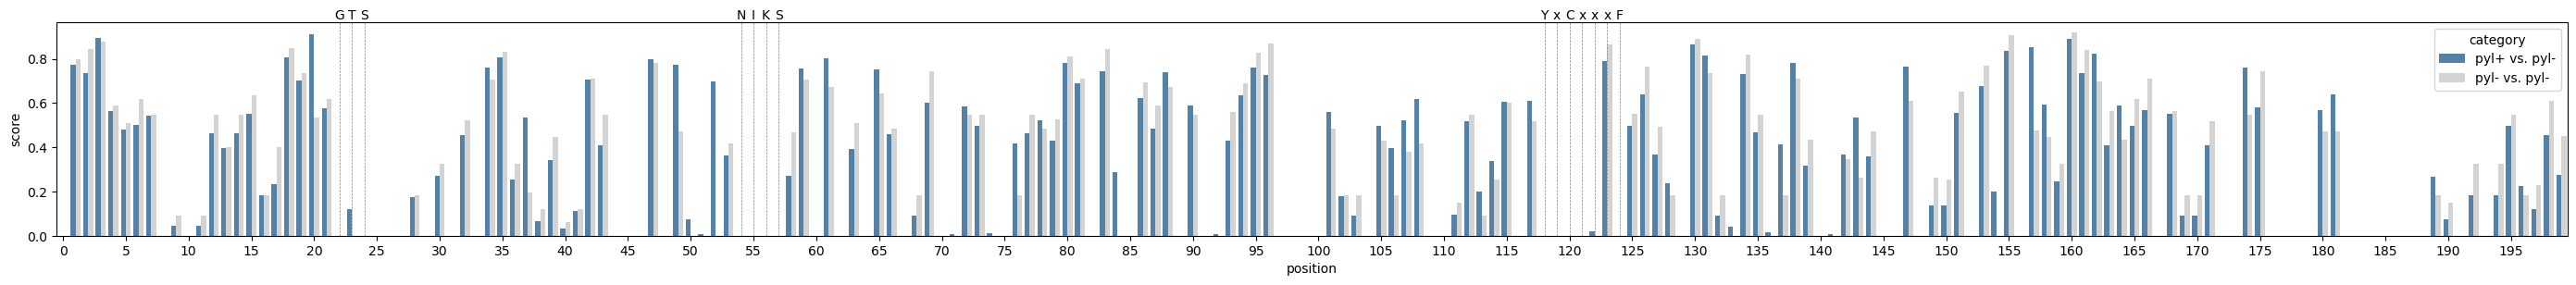

In [14]:
fig, ax = plt.subplots(figsize=(35, 3))
max_position = 200

palette = {'pyl- vs. pyl-':'lightgray', 'pyl+ vs. pyl+':'gray', 'pyl+ vs. pyl-':'steelblue'}

mask = (scores_df['order'] == 'Methanomassiliicoccales') 
# mask = (scores_df['order'] == 'Methanosarcinales') 

figure_df = scores_df[mask].copy()
figure_df = figure_df.groupby(['category', 'position']).score.mean()
figure_df = figure_df.reset_index()
figure_df = figure_df[figure_df.category.isin(['pyl- vs. pyl-', 'pyl+ vs. pyl-'])].copy()
figure_df = figure_df[figure_df.position < max_position].copy()
sns.barplot(figure_df, x='position', y='score', hue='category', palette=palette)
_annotate_residues(domain_boundaries, ax=ax)
ax.set_xticks(np.arange(0, max_position, 5))

print('Residues with high divergence scores:', np.where(figure_df[figure_df.category == 'pyl+ vs. pyl-'].score.values > 0.85)[0])
plt.show()

In [15]:
# def is_conserved_in_genus(alignment_df, position):
#     alignment_df = alignment_df[['genus', position]].copy()
#     return alignment_df.groupby('genus').apply(lambda df : df[position].nunique() == 1, include_groups=False)

def get_residue_distribution(df:pd.DataFrame, position):
    figure_df = list()
    # Want to normalize the counts by genus. 

    for category, df_ in df.groupby('category'):
        df_ = df_.groupby('genus')[position].value_counts(normalize=True).reset_index(name='proportion') # Double check on what this is doing.
        df_ = pd.DataFrame(df_.groupby(position).sum())
        df_['category'] = category
        df_ = df_.drop(columns=['genus'])
        figure_df.append(df_.copy())
    
    figure_df = pd.concat(figure_df)
    figure_df = figure_df.reset_index()
    figure_df = figure_df[figure_df[position] != '-'].copy()
    return figure_df

def plot_residue_distribution(figure_df:pd.DataFrame, position:int=None, ax=None):
    figure_df = get_residue_distribution(figure_df, position)
    palette = {'pyl+':'steelblue', 'pyl-':'lightgray'}
    sns.barplot(figure_df, x=position, y='proportion', hue='category', palette=palette, ax=ax, edgecolor='black')



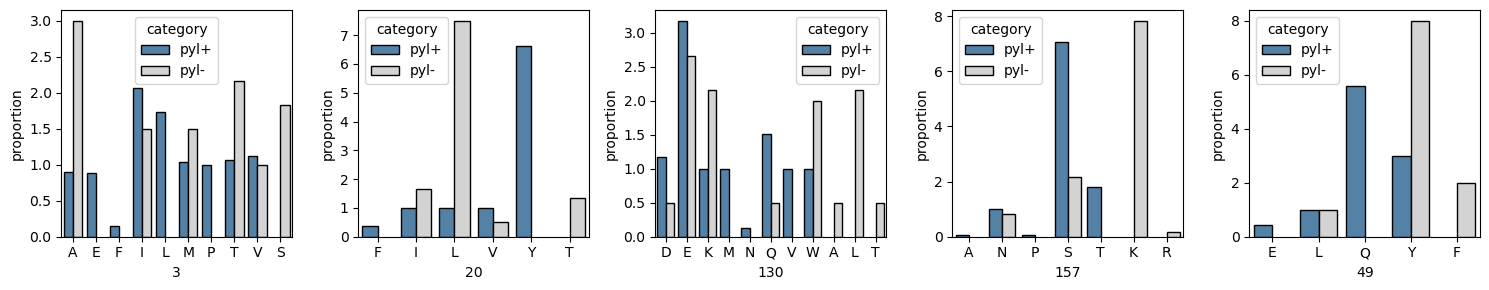

In [16]:
figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 
figure_df['order'] = arf1_df.order
figure_df['genus'] = arf1_df.genus
figure_df = figure_df[figure_df['order'] == 'Methanomassiliicoccales'].copy()

# [ 20  49  52  65 253 270 375]
positions = [3, 20, 130, 157, 49] # [  3  20 130 157 160]
fig, axes = plt.subplots(ncols=len(positions), figsize=(len(positions) * 3, 3))
for position, ax in zip(positions, axes):
    plot_residue_distribution(figure_df, position=position, ax=ax)

fig.tight_layout()

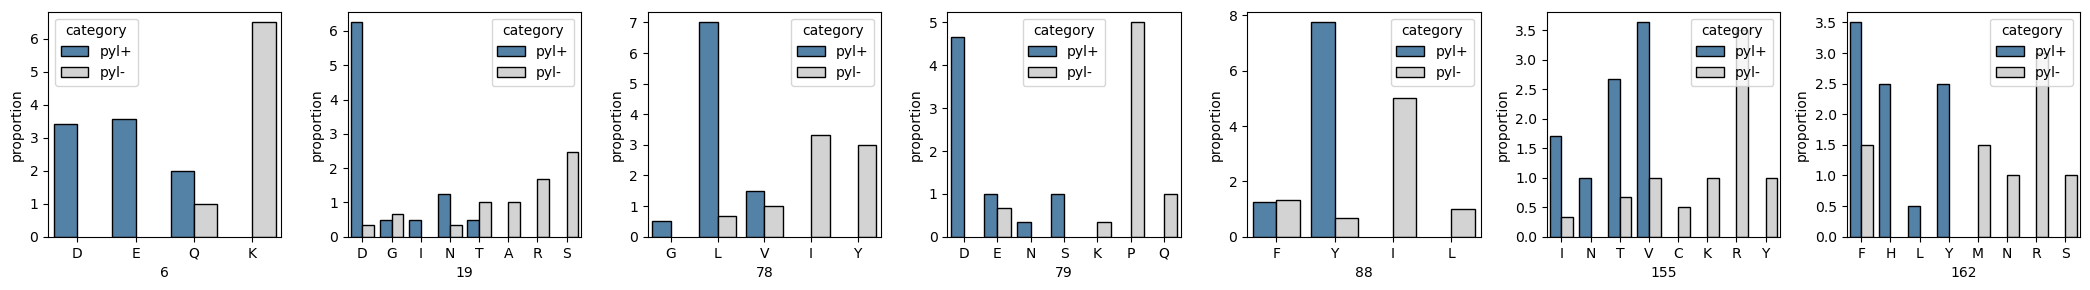

In [ ]:
figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 
figure_df['order'] = arf1_df.order
figure_df['genus'] = arf1_df.genus
figure_df = figure_df[figure_df['order'] == 'Methanosarcinales'].copy()


positions = [6, 19, 78, 79, 88, 155, 162]
fig, axes = plt.subplots(ncols=len(positions), figsize=(len(positions) * 3, 3))
for position, ax in zip(positions, axes):
    plot_residue_distribution(figure_df, position=position, ax=ax)

fig.tight_layout()

In [ ]:
# In theory, if a potential mutation is indeed a development which does something to decrease aRF1 functionality or specificity, it should
# be rare elsewhere in the tree (not just within the order). We can then evaluate the likelihood that a candidate mutation is significant by 
# comparing the divergence metric between members of the same order and 

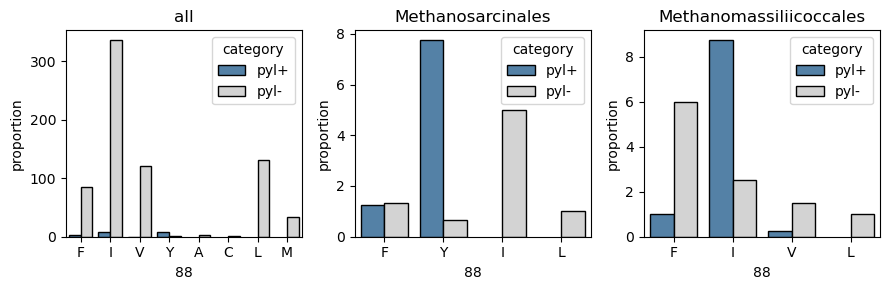

In [34]:
figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 
figure_df['order'] = arf1_df.order
figure_df['genus'] = arf1_df.genus

position = 88

fig, (ax_a, ax_b, ax_c) = plt.subplots(ncols=3, figsize=(9, 3))
plot_residue_distribution(figure_df, position=position, ax=ax_a)
plot_residue_distribution(figure_df[figure_df['order'] == 'Methanosarcinales'], position=position, ax=ax_b)
plot_residue_distribution(figure_df[figure_df['order'] == 'Methanomassiliicoccales'], position=position, ax=ax_c)

ax_a.set_title('all')
ax_b.set_title('Methanosarcinales')
ax_c.set_title('Methanomassiliicoccales')

fig.tight_layout()

In [25]:
# Would be good to have some kind of plot visualizing a correlation between distance (from what?) and 
# where each mutation was acquired. Probably would be helpful to visualize the trees first. 

# Re-load the aRF1 data
arf1_df = load_arf1_dataset(exclude_genome_ids=['GCA_003164755.1'])
alignment_df = load_msa('../data/arf1_cleaned.afa', ids=arf1_df.index, conservation_threshold=0.8)

genome_ids = dict()
genome_ids['methanosarcinales'] = arf1_df[arf1_df['order'] == 'Methanosarcinales'].genome_id.values
genome_ids['methanomassiliicoccales'] = arf1_df[arf1_df['order'] == 'Methanomassiliicoccales'].genome_id.values

position = 78 
field = f'position_{position}'

palette = tree_get_palette_discrete(name='tab20c', values=list('ACDEFGHIKLMNPQRSTVWY'))
palette['-'] = black


for order, genome_ids_ in genome_ids.items():
    arf1_df_ = arf1_df[arf1_df.genome_id.isin(genome_ids_)].copy()
    alignment_df_ = alignment_df.loc[arf1_df_.index].copy()

    tree_write(gtdb_load_ar53_tree(genome_ids=genome_ids_), path=f'../data/trees/ar53_{order}.tree')
    tree_relabel(f'../data/trees/ar53_{order}.tree', f'../data/trees/ar53_{order}_species.tree', label_map={row.genome_id:row.species for row in arf1_df_.itertuples()})

    if position is not None:
        arf1_df_[field] = alignment_df[position]
        styles = {row.species:'bold' for row in arf1_df_[arf1_df_.category != 'pyl-'].itertuples()}
        sizes = {row.species:2 for row in  arf1_df_[arf1_df_.category != 'pyl-'].itertuples()}
        tree_make_annotation_file(arf1_df_.set_index('species'), field=field, palette=palette, path=f'../data/trees/ar53_{order}_{field}_species.txt', styles=styles, sizes=sizes)

In [19]:
palette
#c0d4f5

{'A': '#3182bd',
 'C': '#6baed6',
 'D': '#9ecae1',
 'E': '#c6dbef',
 'F': '#e6550d',
 'G': '#fd8d3c',
 'H': '#fdae6b',
 'I': '#fdd0a2',
 'K': '#31a354',
 'L': '#74c476',
 'M': '#a1d99b',
 'N': '#c7e9c0',
 'P': '#756bb1',
 'Q': '#9e9ac8',
 'R': '#bcbddc',
 'S': '#dadaeb',
 'T': '#636363',
 'V': '#969696',
 'W': '#bdbdbd',
 'Y': '#d9d9d9',
 '-': '#000000'}

In [20]:
gtdb_metadata_df = gtdb_load_ar53_metadata()
gtdb_metadata_df['genome_id'] = gtdb_metadata_df.index

arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0).drop(columns=['genus', 'order', 'Unnamed: 0'])
index = arf1_df.index
arf1_df = arf1_df.merge(gtdb_metadata_df, left_on='genome_id', right_on='genome_id', how='left')
arf1_df.index = index # Restore the index after the merge. 

# Exclude the organism which lost Pyl. 
exclude_genome_id = 'GCA_003164755.1'
arf1_df = arf1_df[arf1_df.genome_id != exclude_genome_id].copy()

stop_codon_genome_metadata_df = pd.read_csv('../data/arf1_stop_codon_metadata.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_genome_metadata_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count

# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')
print('Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories:', (arf1_df.category == 'none').sum())
arf1_df = arf1_df[arf1_df.category != 'none'].copy()

Num. sequences being discarded which are not in either Pyl+ recoded or Pyl- categories: 73


In [ ]:
# def get_residue_distribution(df:pd.DataFrame, position, normalize:bool=True, ignore_gaps:bool=True):
#     distribution_df = list()

#     df = df[df[position] != '-'].copy() if ignore_gaps else df.copy()
#     aas = list('ACDEFGHIKLMNPQRSTVWY') if ignore_gaps else list('ACDEFGHIKLMNPQRSTVWY-')

#     for category, df_ in df.groupby('category'):
#         n_genuses = df_.genus.nunique()
#         # Make sure each genus contributes equally to the final distribution by normalizing the initial count. 
#         df_ = df_.groupby('genus')[position].value_counts(normalize=True).reset_index(name='count')
#         df_ = pd.DataFrame(df_.groupby(position).sum())
#         df_['frequency'] = df_['count'] / n_genuses if normalize else df['count']
#         # df_ = df_.set_index(position) # The position column is the amino acid value. 
#         row = df_['frequency'].to_dict()
#         row.update({aa:0 for aa in aas if (aa not in row)})
#         row.update({'category':category})
#         distribution_df.append(row)

#     distribution_df = pd.DataFrame(distribution_df)
#     distribution_df['position'] = position 
#     return distribution_df